# Predicting Holiday Bookings with Machine Learning  
### *by Alejandra Sevilla*  
---

This Jupyter notebook presents the full pipeline for building a predictive model using customer booking data from British Airways.  

The workflow includes data exploration, preparation, training of a model, evaluating the results, and interpretating the key predictive features.  

## 1. Exploratory data analysis

The goal of this section is to explore the dataset to understand its structure, identify patterns and assess its suitability for predictive modeling.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv("../data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The dataset contains 50,000 booking records with 14 columns describing customer behavior, booking details, and preferences.

All variables are complete (no missing values), but several features are stored as generic `object` types and should be explicitly converted to other formats.

Below is a summary of the dataset’s features:

- `num_passengers`: Number of passengers in the booking  
- `sales_channel`: Channel used to make the booking (`Internet` or `Call Center`)  
- `trip_type`: Type of trip (`Round Trip`, `One Way`, `Circle Trip`)  
- `purchase_lead`: Days between booking date and travel date  
- `length_of_stay`: Days spent at destination  
- `flight_hour`: Hour of departure (0–23)  
- `flight_day`: Day of the week when flight departs  
- `route`: Origin–destination flight route (e.g., `AKLDEL`)  
- `booking_origin`: Country from which the booking was made  
- `wants_extra_baggage`: 1 if customer requested extra baggage  
- `wants_preferred_seat`: 1 if customer requested a preferred seat  
- `wants_in_flight_meals`: 1 if customer requested meals onboard  
- `flight_duration`: Duration of the flight in hours  
- `booking_complete`: Target variable (1 = booking completed, 0 = not completed)

Categorical variables are now modified to appropriate formats for analysis and modeling.

In [4]:
# Inspect original values in 'flight_day'
print("Original flight_day values:", df["flight_day"].unique())

# Map day names to ordinal values 
flight_day_mapping = {
    "Mon": 0,
    "Tue": 1,
    "Wed": 2,
    "Thu": 3,
    "Fri": 4,
    "Sat": 5,
    "Sun": 6,
}
df["flight_day"] = df["flight_day"].map(flight_day_mapping)

# Confirm mapping applied correctly
print("Mapped flight_day values:", df["flight_day"].unique())


Original flight_day values: ['Sat' 'Wed' 'Thu' 'Mon' 'Sun' 'Tue' 'Fri']
Mapped flight_day values: [5 2 3 0 6 1 4]


In [5]:
# Inspect original values in 'sales_channel'
print("Original sales_channel values:", df["sales_channel"].unique())

# Updated mapping for sales_channel
sales_channel_mapping = {
    "Internet": 0,
    "Mobile": 1
}
df["sales_channel"] = df["sales_channel"].map(sales_channel_mapping)

# Confirm mapping applied correctly
print("Mapped sales_channel values:", df["sales_channel"].unique())

Original sales_channel values: ['Internet' 'Mobile']
Mapped sales_channel values: [0 1]


In [6]:
# Inspect original values in 'trip_type'
print("Original trip_type values:", df["trip_type"].unique())

# Map trip_type to numeric codes
trip_type_mapping = {
    "OneWay": 0,
    "RoundTrip": 1,
    "CircleTrip": 2
}
df["trip_type"] = df["trip_type"].map(trip_type_mapping)

# Confirm transformation
print("Mapped trip_type values:", df["trip_type"].unique())

Original trip_type values: ['RoundTrip' 'CircleTrip' 'OneWay']
Mapped trip_type values: [1 2 0]


In [7]:
print("Unique routes:", df["route"].nunique())
print("Top 5 most common routes:\n", df["route"].value_counts().head())

Unique routes: 799
Top 5 most common routes:
 route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
Name: count, dtype: int64


The `route` variable contains concatenated origin–destination airport codes (e.g., `AKLKUL`).  

Since the number of unique routes is too high for direct encoding, this feature is decomposed into two separate variables: `origin` and `destination`.

In [8]:
# Split 'route' into 'origin' and 'destination' airport codes
df["origin"] = df["route"].str[:3]
df["destination"] = df["route"].str[3:]

# Drop the original 'route' column
df.drop("route", axis=1, inplace=True)

# Confirm the new columns
print("Origin airports (top 5):\n", df["origin"].value_counts().head())
print("\nDestination airports (top 5):\n", df["destination"].value_counts().head())


Origin airports (top 5):
 origin
DMK    3747
ICN    3732
MEL    3468
DPS    2902
AKL    2849
Name: count, dtype: int64

Destination airports (top 5):
 destination
SYD    6616
PER    4992
MEL    4444
TPE    4044
OOL    2796
Name: count, dtype: int64


The `origin` and `destination` variables contain over 50 unique airport codes each, which would result in high-dimensional and sparse feature matrices if one-hot encoded directly.

To reduce dimensionality while preserving the most frequent values, the top 10 most frequent airports in each column are preserved and all other values are grouped under a common `"Other"` category.

In [9]:
# Keep top 10 most common origin airports, group others as 'Other'
top_origins = df["origin"].value_counts().head(10).index
df["origin_grouped"] = df["origin"].apply(lambda x: x if x in top_origins else "Other")

# Keep top 10 most common destination airports, group others as 'Other'
top_destinations = df["destination"].value_counts().head(10).index
df["destination_grouped"] = df["destination"].apply(lambda x: x if x in top_destinations else "Other")

# Drop original origin/destination columns if not needed
df.drop(["origin", "destination"], axis=1, inplace=True)

# Confirm grouping worked
print("Grouped origin values:\n", df["origin_grouped"].value_counts())
print("\nGrouped destination values:\n", df["destination_grouped"].value_counts())


Grouped origin values:
 origin_grouped
Other    23018
DMK       3747
ICN       3732
MEL       3468
DPS       2902
AKL       2849
HKT       2387
CGK       2339
PEN       2111
HND       1774
COK       1673
Name: count, dtype: int64

Grouped destination values:
 destination_grouped
Other    15327
SYD       6616
PER       4992
MEL       4444
TPE       4044
OOL       2796
KUL       2688
PEN       2483
KIX       2240
ICN       2213
SIN       2157
Name: count, dtype: int64


After reducing the cardinality of the `origin` and `destination` airport columns by grouping less common values under `"Other"`, the resulting `origin_grouped` and `destination_grouped` variables are one-hot encoded.

This transformation converts each airport category into a binary feature.


In [10]:
# One-hot encode grouped origin and destination
df = pd.get_dummies(
    df,
    columns=["origin_grouped", "destination_grouped"],
    drop_first=True
)

# Confirm updated shape and example
print("Data shape after encoding:", df.shape)
df.head()

Data shape after encoding: (50000, 33)


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,...,destination_grouped_KIX,destination_grouped_KUL,destination_grouped_MEL,destination_grouped_OOL,destination_grouped_Other,destination_grouped_PEN,destination_grouped_PER,destination_grouped_SIN,destination_grouped_SYD,destination_grouped_TPE
0,2,0,1,262,19,7,5,New Zealand,1,0,...,False,False,False,False,True,False,False,False,False,False
1,1,0,1,112,20,3,5,New Zealand,0,0,...,False,False,False,False,True,False,False,False,False,False
2,2,0,1,243,22,17,2,India,1,1,...,False,False,False,False,True,False,False,False,False,False
3,1,0,1,96,31,4,5,New Zealand,0,0,...,False,False,False,False,True,False,False,False,False,False
4,2,0,1,68,22,15,2,India,1,0,...,False,False,False,False,True,False,False,False,False,False


In [11]:
# Check unique booking_origin values
print("Unique booking_origin values:", df["booking_origin"].nunique())
print("\nTop 10 most common booking_origin values:\n", df["booking_origin"].value_counts().head(10))

# Group booking_origin into top 10 + 'Other'
top_origins = df["booking_origin"].value_counts().head(10).index
df["booking_origin_grouped"] = df["booking_origin"].apply(lambda x: x if x in top_origins else "Other")

# Drop original booking_origin column
df.drop("booking_origin", axis=1, inplace=True)

# Confirm grouping
print("Grouped booking_origin values:\n", df["booking_origin_grouped"].value_counts())

Unique booking_origin values: 104

Top 10 most common booking_origin values:
 booking_origin
Australia      17872
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
Indonesia       2369
Taiwan          2077
Thailand        2030
India           1270
New Zealand     1074
Name: count, dtype: int64
Grouped booking_origin values:
 booking_origin_grouped
Australia      17872
Malaysia        7174
South Korea     4559
Other           4303
Japan           3885
China           3387
Indonesia       2369
Taiwan          2077
Thailand        2030
India           1270
New Zealand     1074
Name: count, dtype: int64


To handle the high-cardinality `booking_origin` variable, only the 10 most frequent countries were retained as individual categories. All other countries were grouped under the `"Other"` label.

In [12]:
# One-hot encode the grouped booking_origin column
df = pd.get_dummies(
    df,
    columns=["booking_origin_grouped"],
    drop_first=True
)

# Confirm shape and sample
print("Data shape after encoding:", df.shape)
df.head()

Data shape after encoding: (50000, 42)


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,...,booking_origin_grouped_China,booking_origin_grouped_India,booking_origin_grouped_Indonesia,booking_origin_grouped_Japan,booking_origin_grouped_Malaysia,booking_origin_grouped_New Zealand,booking_origin_grouped_Other,booking_origin_grouped_South Korea,booking_origin_grouped_Taiwan,booking_origin_grouped_Thailand
0,2,0,1,262,19,7,5,1,0,0,...,False,False,False,False,False,True,False,False,False,False
1,1,0,1,112,20,3,5,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2,2,0,1,243,22,17,2,1,1,0,...,False,True,False,False,False,False,False,False,False,False
3,1,0,1,96,31,4,5,0,0,1,...,False,False,False,False,False,True,False,False,False,False
4,2,0,1,68,22,15,2,1,0,1,...,False,True,False,False,False,False,False,False,False,False


After completing the categorical encoding process, many of the resulting features are stored as boolean values (`True`/`False`). All boolean columns in the dataset are converted to integer type.

In [13]:
# Convert all boolean columns to integers (0 and 1)
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

In [14]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   num_passengers                      50000 non-null  int64  
 1   sales_channel                       50000 non-null  int64  
 2   trip_type                           50000 non-null  int64  
 3   purchase_lead                       50000 non-null  int64  
 4   length_of_stay                      50000 non-null  int64  
 5   flight_hour                         50000 non-null  int64  
 6   flight_day                          50000 non-null  int64  
 7   wants_extra_baggage                 50000 non-null  int64  
 8   wants_preferred_seat                50000 non-null  int64  
 9   wants_in_flight_meals               50000 non-null  int64  
 10  flight_duration                     50000 non-null  float64
 11  booking_complete                    50000

In [15]:
df.describe()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,...,booking_origin_grouped_China,booking_origin_grouped_India,booking_origin_grouped_Indonesia,booking_origin_grouped_Japan,booking_origin_grouped_Malaysia,booking_origin_grouped_New Zealand,booking_origin_grouped_Other,booking_origin_grouped_South Korea,booking_origin_grouped_Taiwan,booking_origin_grouped_Thailand
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,0.112360,0.994580,84.940480,23.04456,9.06634,2.814420,0.668780,0.296960,0.427140,...,0.067740,0.025400,0.047380,0.077700,0.143480,0.021480,0.086060,0.091180,0.041540,0.040600
std,1.020165,0.315812,0.100154,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,...,0.251302,0.157338,0.212452,0.267702,0.350565,0.144979,0.280455,0.287868,0.199538,0.197364
min,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,21.000000,5.00000,5.00000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,51.000000,17.00000,9.00000,3.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,1.000000,115.000000,28.00000,13.00000,4.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,1.000000,2.000000,867.000000,778.00000,23.00000,6.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Exploratory Visualizations

Before training the predictive model, the dataset is explored using visualizations to identify patterns, trends, and relationships.

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modeling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

Based on the `.describe()` summary, the `trip_type` variable appears highly imbalanced:

- Most trips fall under the "RoundTrip" category (coded as `1`)
- "OneWay" (`0`) and "CircleTrip" (`2`) are far less frequent

This imbalance may influence model performance or feature importance. We explore its distribution below to confirm the imbalance.


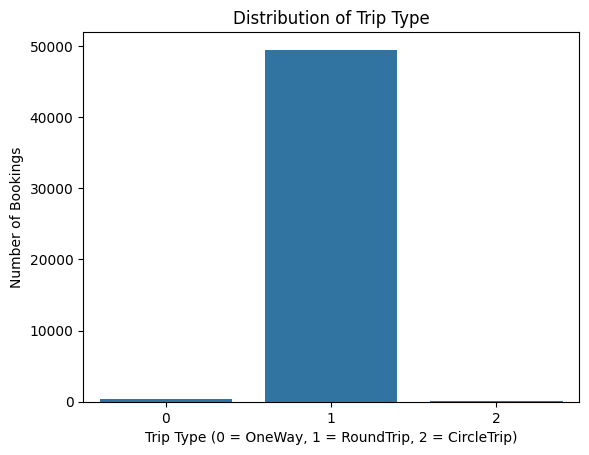

In [16]:
sns.countplot(x="trip_type", data=df)
plt.title("Distribution of Trip Type")
plt.xlabel("Trip Type (0 = OneWay, 1 = RoundTrip, 2 = CircleTrip)")
plt.ylabel("Number of Bookings")
plt.show()

The `trip_type` variable originally contained three categories:
- `0` = OneWay
- `1` = RoundTrip
- `2` = CircleTrip

However, nearly all records fall into the `RoundTrip` category. This extreme imbalance means that the model would gain little from treating `trip_type` as a 3-class categorical feature.

To simplify and reduce noise, a binary flag is created:
**`is_round_trip` = 1 if the trip is RoundTrip, 0 otherwise**


In [17]:
# Convert 'trip_type' to binary flag: 1 if RoundTrip, 0 otherwise
df["is_round_trip"] = (df["trip_type"] == 1).astype(int)

# Drop the original 'trip_type' column
df.drop("trip_type", axis=1, inplace=True)

# Confirm changes
print(df[["is_round_trip"]].value_counts())

is_round_trip
1                49497
0                  503
Name: count, dtype: int64


Both `purchase_lead` and `length_of_stay` display extremely long tails:

- `purchase_lead`: up to **867 days** before travel
- `length_of_stay`: up to **778 days** at the destination

These long-tailed distributions may skew summary statistics and impact model performance.

I will:
- Visualize the distributions
- Check for potential outliers
- Consider a log transformation.


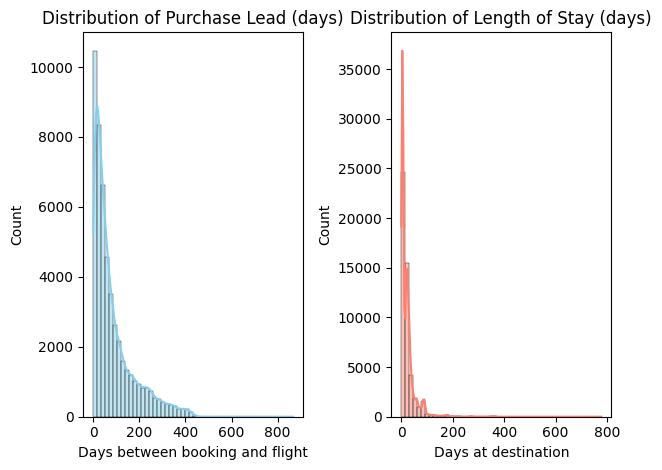

In [18]:
# Plot purchase_lead
plt.subplot(1, 2, 1)
sns.histplot(df["purchase_lead"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Purchase Lead (days)")
plt.xlabel("Days between booking and flight")

# Plot length_of_stay
plt.subplot(1, 2, 2)
sns.histplot(df["length_of_stay"], bins=50, kde=True, color="salmon")
plt.title("Distribution of Length of Stay (days)")
plt.xlabel("Days at destination")

plt.tight_layout()
plt.show()

The histograms reveal strong right-skewness in both `purchase_lead` and `length_of_stay`, with a concentration of bookings and stays under 200 days and rare extreme values above 600.

To reduce skewness and stabilize the range for modeling, we apply a **log(1 + x)** transformation to both features.

In [19]:
# Apply log(1 + x) to handle zero values safely
df["purchase_lead_log"] = np.log1p(df["purchase_lead"])
df["length_of_stay_log"] = np.log1p(df["length_of_stay"])
df.drop(["purchase_lead", "length_of_stay"], axis=1, inplace=True)


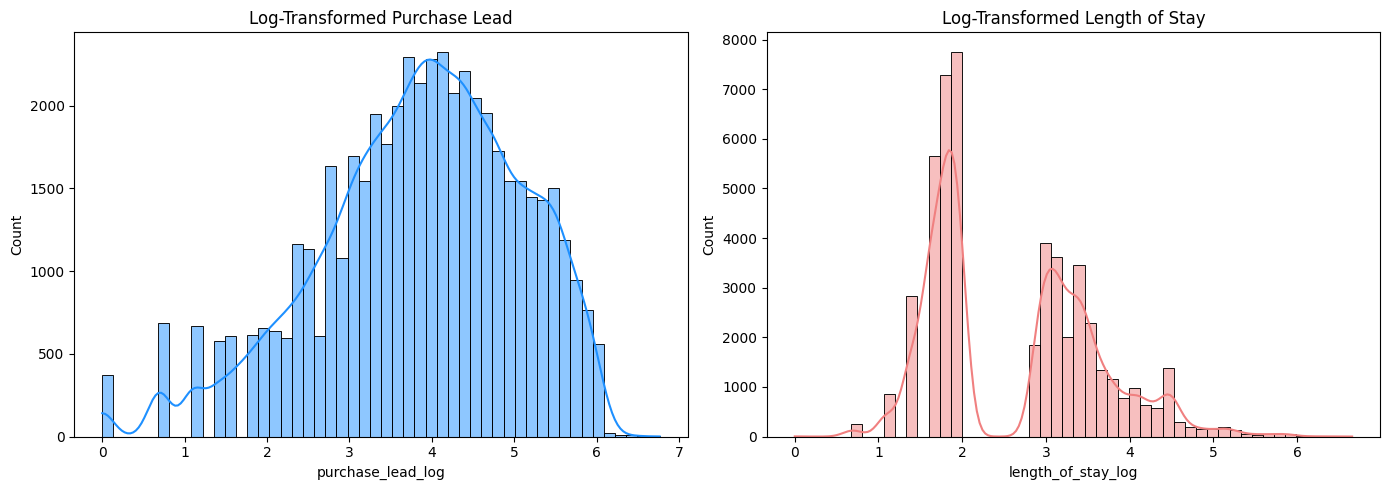

In [20]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df["purchase_lead_log"], bins=50, kde=True, color="dodgerblue")
plt.title("Log-Transformed Purchase Lead")

plt.subplot(1, 2, 2)
sns.histplot(df["length_of_stay_log"], bins=50, kde=True, color="lightcoral")
plt.title("Log-Transformed Length of Stay")

plt.tight_layout()
plt.show()

Most bookings are made through the `Internet` channel as shown by the low mean value (0.11) of the binary-encoded `sales_channel` variable.

To explore whether booking completion differs by channel, we plot the **conversion rate** (i.e., % of bookings completed) for each channel.

/var/folders/p0/wvxjb5fx0bz1445xb4c17hzc0000gn/T/ipykernel_35570/2610106436.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conversion_by_channel, x="sales_channel", y="booking_complete", palette="Blues_d")


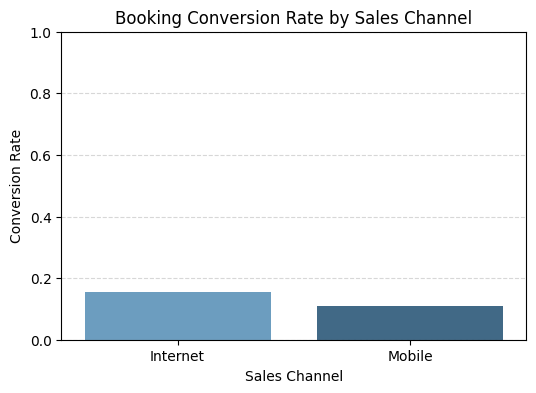

In [21]:
# Calculate conversion rate by sales channel
conversion_by_channel = df.groupby("sales_channel")["booking_complete"].mean().reset_index()

# Map channel names for clarity
conversion_by_channel["sales_channel"] = conversion_by_channel["sales_channel"].map({0: "Internet", 1: "Mobile"})

plt.figure(figsize=(6,4))
sns.barplot(data=conversion_by_channel, x="sales_channel", y="booking_complete", palette="Blues_d")
plt.title("Booking Conversion Rate by Sales Channel")
plt.ylabel("Conversion Rate")
plt.xlabel("Sales Channel")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


**Internet** bookings dominate in volume and also show a higher conversion rate.
**Call Center (mobile)** bookings convert at a lower rate (~11%), despite representing a smaller portion of the dataset.

This suggests that digital channels are both more popular and more effective in driving completed bookings. It may be worth investigating further whether Call Center users face friction or represent more complex booking scenarios.


The distribution of `num_passengers` is heavily skewed toward 1 passenger per booking (median = 1). The mean is ~1.6, and the maximum is 9 passengers.

Let’s explore whether more passengers are associated with higher or lower booking completion rates.


/var/folders/p0/wvxjb5fx0bz1445xb4c17hzc0000gn/T/ipykernel_35570/2423966512.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="num_passengers", y="booking_complete", data=conversion_by_passengers, palette="Blues_d")


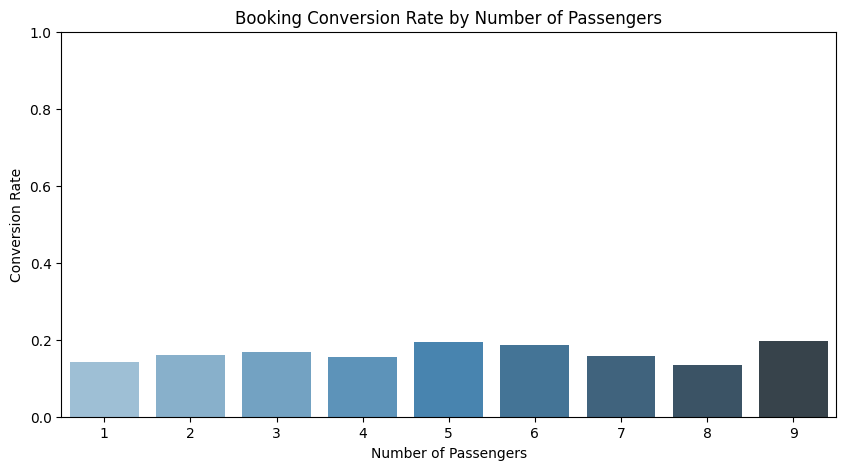

In [22]:
# Calculate conversion rate by passenger count
conversion_by_passengers = df.groupby("num_passengers")["booking_complete"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="num_passengers", y="booking_complete", data=conversion_by_passengers, palette="Blues_d")
plt.title("Booking Conversion Rate by Number of Passengers")
plt.xlabel("Number of Passengers")
plt.ylabel("Conversion Rate")
plt.ylim(0, 1)
plt.show()


Number of passengers doesn’t have a strong linear relationship with booking completion, but there may be interesting edge cases at high passenger counts (e.g. planned group travel).

To better understand customer booking behavior, we explored the distribution of the `num_passengers` variable using a histogram. The goal was to identify how many people typically travel in a single booking and whether larger groups behave differently.

Understanding this distribution can inform:

- How individual vs. group travelers differ in behavior.
- Whether to engineer features (e.g., `is_group_booking`) that better capture booking tendencies for different passenger group sizes.

/var/folders/p0/wvxjb5fx0bz1445xb4c17hzc0000gn/T/ipykernel_35570/1384471796.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="num_passengers", data=df, palette="Blues")


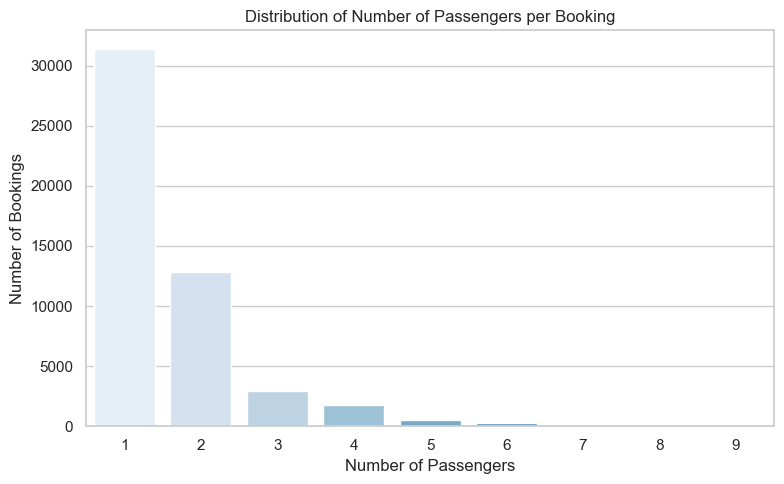

In [23]:
# Set plot style
sns.set(style="whitegrid")

# Create histogram of num_passengers
plt.figure(figsize=(8, 5))
sns.countplot(x="num_passengers", data=df, palette="Blues")

plt.title("Distribution of Number of Passengers per Booking")
plt.xlabel("Number of Passengers")
plt.ylabel("Number of Bookings")
plt.tight_layout()
plt.show()


This chart shows that most bookings are made for solo travelers or pairs. Over 60% of all bookings are for just 1 passenger, and nearly 90% are for 1 or 2 passengers combined. Larger group bookings (4 or more) are relatively rare, which may have implications for targeting and resource planning.

### Target Variable Distribution: `booking_complete`

Before modeling, we inspect the distribution of the target variable (`booking_complete`) to detect any class imbalance.

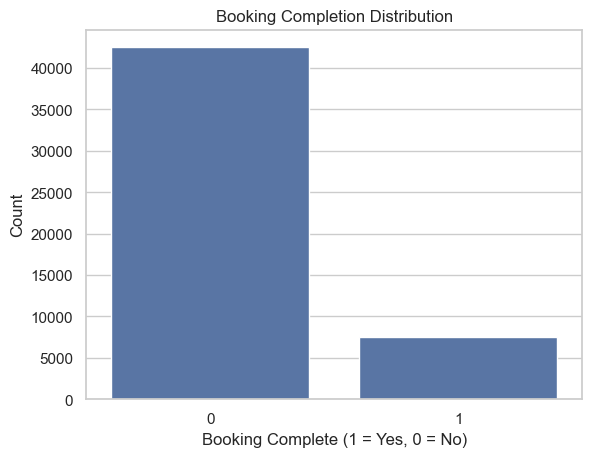

In [24]:
sns.countplot(x="booking_complete", data=df)
plt.title("Booking Completion Distribution")
plt.xlabel("Booking Complete (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

As shown , only ~15% of customers complete a booking (`1`), while ~85% do not (`0`). This imbalance must be taken into account to avoid overly optimistic model performance driven by the majority class.

We'll address this during model evaluation by:
- Using metrics like F1-score and ROC AUC, not just accuracy.
- Applying stratified sampling to ensure balanced representation in training/testing splits.


Understanding whether the day of the week influences booking completion can reveal behavioral patterns. For instance, are users less likely to finalize bookings during weekends?

This chart shows the average booking completion rate by flight day (1 = Monday, 7 = Sunday).

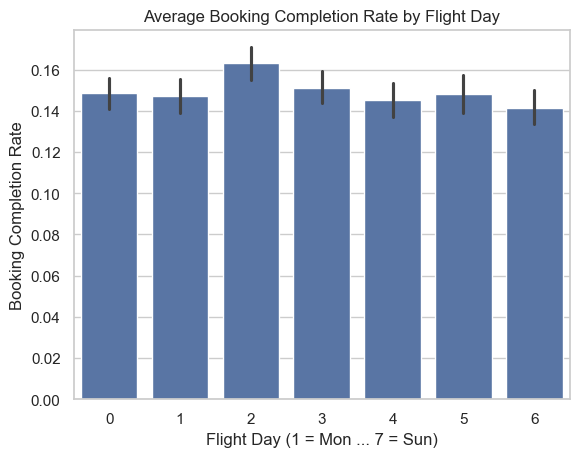

In [25]:
sns.barplot(x="flight_day", y="booking_complete", data=df)
plt.title("Average Booking Completion Rate by Flight Day")
plt.xlabel("Flight Day (1 = Mon ... 7 = Sun)")
plt.ylabel("Booking Completion Rate")
plt.show()

The booking completion rate is fairly consistent across days, with only minor variation.

- Day 3 (Wednesday) shows a slightly higher conversion rate (~16.5%).
- Other days hover around 14–15%, suggesting flight day has limited influence on booking outcomes.

*Takeaway:* Flight day may not be a strong standalone predictor, but it's reasonable to keep it as part of the feature set.


Purchasing add-ons like extra baggage may signal higher intent to book. This visualization explores whether wanting extra baggage correlates with a higher likelihood of completing the booking.

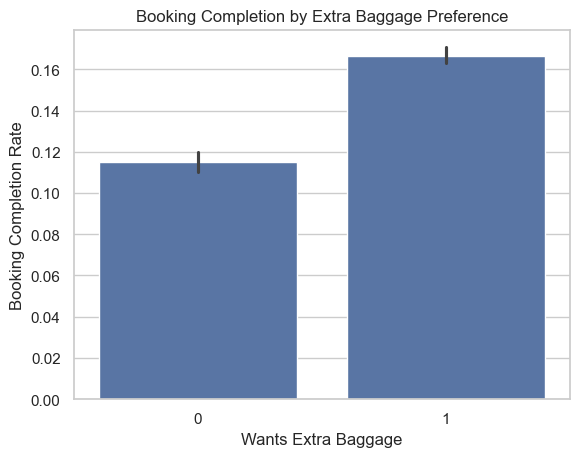

In [26]:
sns.barplot(x="wants_extra_baggage", y="booking_complete", data=df)
plt.title("Booking Completion by Extra Baggage Preference")
plt.xlabel("Wants Extra Baggage")
plt.ylabel("Booking Completion Rate")
plt.show()

Customers who request extra baggage are significantly more likely to complete a booking:

- Completion rate for those without extra baggage: ~11.5%
- Completion rate for those*with extra baggage: ~16.5%

*Interpretation:* Wanting extra baggage may signal higher travel commitment or intent, making this a strong predictive signal.


In [27]:
df.describe()

,num_passengers,sales_channel,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,origin_grouped_CGK,...,booking_origin_grouped_Japan,booking_origin_grouped_Malaysia,booking_origin_grouped_New Zealand,booking_origin_grouped_Other,booking_origin_grouped_South Korea,booking_origin_grouped_Taiwan,booking_origin_grouped_Thailand,is_round_trip,purchase_lead_log,length_of_stay_log
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,0.112360,9.06634,2.814420,0.668780,0.296960,0.427140,7.277561,0.149560,0.046780,...,0.077700,0.143480,0.021480,0.086060,0.091180,0.041540,0.040600,0.989940,3.849321,2.629133
std,1.020165,0.315812,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643,0.211169,...,0.267702,0.350565,0.144979,0.280455,0.287868,0.199538,0.197364,0.099795,1.232387,1.005382
min,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4.670000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,5.00000,1.000000,0.000000,0.000000,0.000000,5.620000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.091042,1.791759
50%,1.000000,0.000000,9.00000,3.000000,1.000000,0.000000,0.000000,7.570000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.951244,2.890372
75%,2.000000,0.000000,13.00000,4.000000,1.000000,1.000000,1.000000,8.830000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.753590,3.367296
max,9.000000,1.000000,23.00000,6.000000,1.000000,1.000000,1.000000,9.500000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.766192,6.658011


## 2. Prepare Data for Modeling

In this section, we prepare the dataset for training a predictive model.  This includes separating features and target, splitting the data into training and testing sets, and ensuring the target variable's class distribution is preserved using stratified sampling.

In [28]:
# 1. Separate target and features
X = df.drop("booking_complete", axis=1)
y = df["booking_complete"]

# 2. Split into train and test sets (stratify to preserve class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Booking completion rate in train set:", y_train.mean())

Train shape: (40000, 41)
Test shape: (10000, 41)
Booking completion rate in train set: 0.14955


## 2. Train and Evaluate Predictive Model
In this section, we train a Random Forest Classifier to predict whether a customer will complete a booking.
We account for the strong class imbalance using `class_weight="balanced"`, ensuring the model doesn't favor the majority class (`booking_complete = 0`).

We evaluate the model using appropriate metrics such as **F1-score** and **ROC AUC**, which are more informative than accuracy for imbalanced classification problems.

In [29]:
# Initialize Random Forest with class_weight to handle imbalance
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [30]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[8334  170]
 [1330  166]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      8504
           1       0.49      0.11      0.18      1496

    accuracy                           0.85     10000
   macro avg       0.68      0.55      0.55     10000
weighted avg       0.81      0.85      0.81     10000

ROC AUC Score: 0.770403814373607


The default model predictions (using a threshold of 0.5) show high overall accuracy (85%) and strong performance for class 0 (non-bookers). However, the recall for class 1 (customers who completed a booking) is only 0.11, indicating the model misses most true positives.

This is a common issue in imbalanced classification problems, where the minority class (in this case, completed bookings) is underrepresented and often ignored by standard thresholds.

To address this, I experimented with lowering the decision threshold to increase the model's sensitivity to class 1. This means predicting a positive class (booking completed) even if the probability is below 0.5.

In [31]:
thresholds = [0.5, 0.4, 0.35, 0.3, 0.25, 0.2]

print("Threshold | Precision | Recall | F1-Score")
print("--------------------------------------------")
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    print(f"{thresh:9.2f} | {precision:9.2f} | {recall:6.2f} | {f1:8.2f}")


Threshold | Precision | Recall | F1-Score
--------------------------------------------
     0.50 |      0.49 |   0.12 |     0.19
     0.40 |      0.41 |   0.22 |     0.29
     0.35 |      0.39 |   0.30 |     0.34
     0.30 |      0.36 |   0.39 |     0.38
     0.25 |      0.35 |   0.50 |     0.41
     0.20 |      0.32 |   0.63 |     0.43


By adjusting the threshold, I was able to significantly improve the recall for bookings, trading off some precision for better coverage of the positive class. This strategy is especially useful in contexts where missing a potential booking is more costly than a false positive prediction.

## 3. Feature Importance Analysis – Why and How
To better understand which features drive the model’s ability to predict bookings, I used permutation-based feature importance. This method evaluates the actual drop in F1 Score when a feature is randomly shuffled, making it a more reliable indicator of a variable’s predictive power compared to tree impurity-based measures.

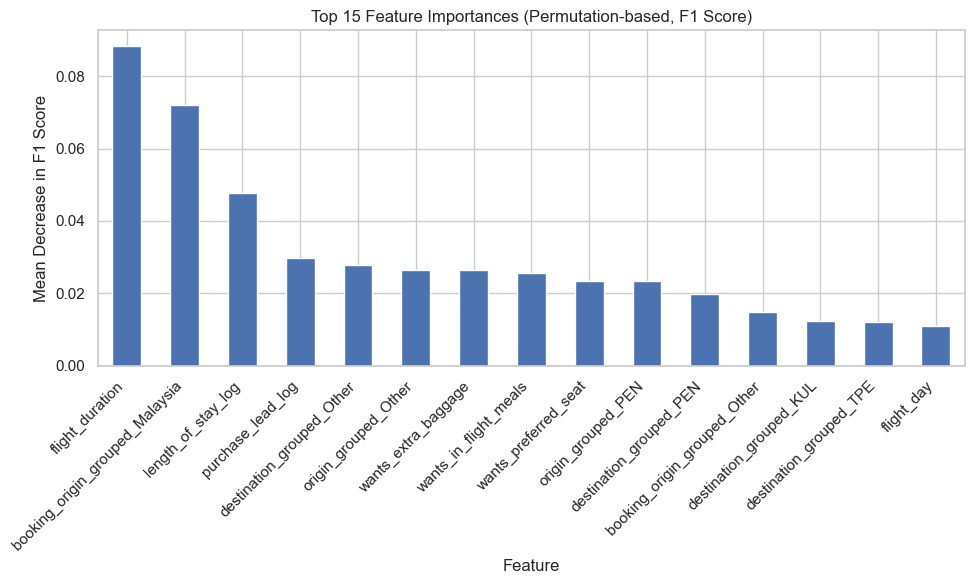

In [32]:
# Compute permutation importance based on F1 Score
perm_result = permutation_importance(
    rf_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

# Convert to Series for better visualization
perm_importances = pd.Series(perm_result.importances_mean, index=X_test.columns)

# Plot the Top 15 most important features
plt.figure(figsize=(10, 6))
perm_importances.sort_values(ascending=False).head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances (Permutation-based, F1 Score)")
plt.ylabel("Mean Decrease in F1 Score")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 🧠 Feature Importance Interpretation

The plot above shows the top 15 features ranked by their impact on the F1 score when permuted. The higher the drop, the more important the feature.

### Top Drivers of Booking Completion:

1. `flight_duration` – The most predictive variable. Likely reflects trip complexity or distance influencing user decision.

2. `booking_origin_grouped_Malaysia` – Indicates strong geographic patterns in booking behavior.

3. `length_of_stay_log` – Trip duration plays a key role in predicting booking likelihood.

4. `purchase_lead_log` – Shorter lead times tend to correlate with completed bookings.

5. `destination_grouped_Other` – Destinations not among the top most frequent still carry predictive value.

### Behavioral Variables Matter:

Features like:

* `wants_extra_baggage`

* `wants_in_flight_meals`

* `wants_preferred_seat`

are meaningful, suggesting that customer preferences are good indicators of intent to book.

---

### Takeaway

This analysis highlights both trip characteristics and user preferences as key predictors. This insight could inform:

* Marketing segmentation

* UX optimizations (e.g., highlighting meal/baggage options)

* Pricing strategies based on booking patterns by origin and duration
